In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import sys
sys.path.insert(1, '../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
sys.path.insert(1, '../../../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
from api_calls import *

url = "https://nomad-hzb-ce.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN']

### EDAQ Analysis

**Insert the name of your data file here.** You can also adapt the other parameters.

In [2]:
upload_name = '250502_GZ_Cu_nanop_NO3RR_benchmark'
run_number = 1

gse_file_name = f'exampledata_GSE_CP{run_number}.txt'

start_volume = 70
sample_area = 0.126

# GSE calibration curve parameters (recorded 25.04.2025)
slope = -55.58
intercept = 31.72

faradaic_constant = 96485.33
z = 8

R = 50
ref = 0.893

In [3]:
cp_data_list = get_specific_entrytype_of_uploads(url, token, [upload_name], 'CE_NOME_Chronopotentiometry', with_meta=False)
cp_data = next((item for item in cp_data_list if item.get('data_file', '').endswith(f'#{run_number}.DTA')), None)
cp_current = cp_data.get('properties').get('step_1_current')
print(f'cp current: {cp_current} A')

volume_cell = (start_volume - run_number) / 1000
print(f'cell volume: {volume_cell}')

cp current: -3.2e-05 A
cell volume: 0.069


Now we can do all calculations.

In [4]:
def get_derivative(x_col, fx_col):
    return np.gradient(fx_col, x_col)

In [5]:
data = pd.read_csv(gse_file_name, skiprows=4, sep=' ', header=None, names=['Time [s]', 'Potential [mV]', 'CP Potential [mV]'])
data['Time [s]'] = pd.to_timedelta(data['Time [s]']).dt.total_seconds()

data['CP Potential - iR [mV]'] = data['CP Potential [mV]'] * (-1) / 1000 - cp_current * R + ref

#from GSE potential profile to NH3 concentration profile [uM]
data['conc_NH3 [µM]'] = 10 ** ((data['Potential [mV]'] - intercept) / slope)
# smooth conc data
smoothed = lowess(endog=data['conc_NH3 [µM]'], exog=data['Time [s]'], frac=0.1)  # frac is used to tune the smoothing
data['conc_NH3_smoothed'] = smoothed[:, 1]
# first derivative NH3 concentration
data['rate NH3 [µM/s]'] = get_derivative(data['Time [s]'], data['conc_NH3_smoothed'])
data['rate NH3 [nmol/s*cm²]'] = data['rate NH3 [µM/s]'] * 1000 * volume_cell / sample_area
# second derivative NH3 concentration
data['conc_NH3_second_derivative'] = get_derivative(data['Time [s]'], data['rate NH3 [µM/s]'])

data['FE [%]'] = data['rate NH3 [nmol/s*cm²]'] * sample_area * faradaic_constant * z * (10 ** -7) / np.abs(cp_current)

# uncomment the next row to see all rows
# pd.set_option('display.max_rows', None)
data

,Time [s],Potential [mV],CP Potential [mV],CP Potential - iR [mV],conc_NH3 [µM],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],conc_NH3_second_derivative,FE [%]
0,1.0,54.14,184.68,0.70992,0.395019,0.389385,0.000888,0.486469,-4.953808e-09,147.851935
1,2.0,54.14,184.68,0.70992,0.395019,0.390274,0.000888,0.486466,-8.035954e-09,147.851111
2,3.0,54.12,417.00,0.47760,0.395346,0.391162,0.000888,0.486460,-1.239518e-08,147.849260
3,4.0,54.12,417.00,0.47760,0.395346,0.392050,0.000888,0.486453,-1.576690e-08,147.846985
4,5.0,54.25,622.59,0.27201,0.393222,0.392939,0.000888,0.486443,-2.334146e-08,147.844012
...,...,...,...,...,...,...,...,...,...,...
610,611.0,45.96,385.66,0.50894,0.554361,0.554290,0.000003,0.001760,-2.417010e-08,0.534901
611,612.0,45.96,385.66,0.50894,0.554361,0.554293,0.000003,0.001750,-1.203302e-08,0.531956
612,613.0,45.95,504.38,0.39022,0.554591,0.554296,0.000003,0.001747,-2.257687e-09,0.530896
613,614.0,45.95,504.38,0.39022,0.554591,0.554299,0.000003,0.001748,2.164294e-09,0.531205


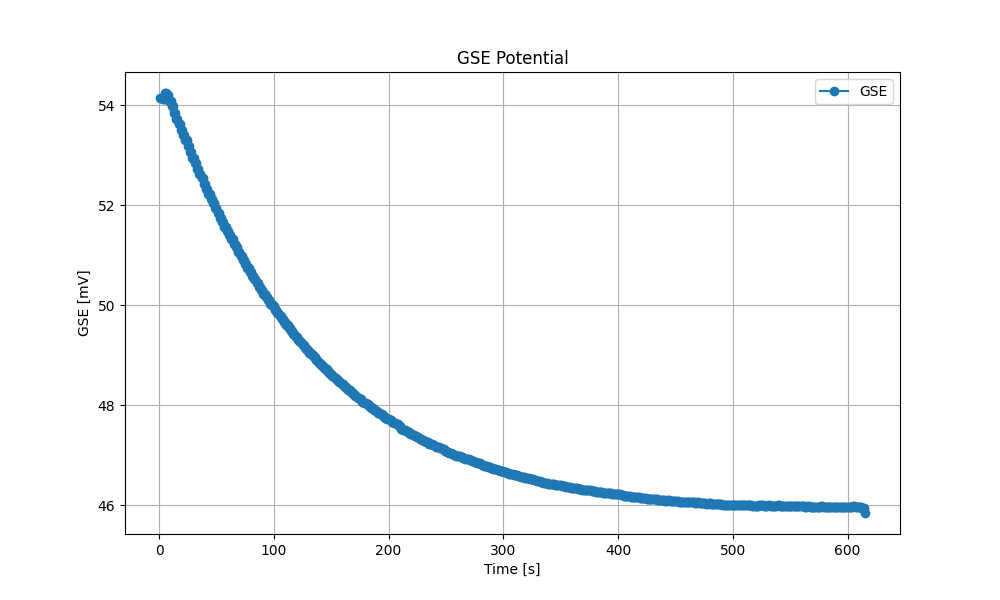

In [6]:
# make plot
plt.figure(figsize=(10, 6))
plt.plot(data['Time [s]'], data['Potential [mV]'], label='GSE', marker='o')

# label axis
plt.xlabel('Time [s]')
plt.ylabel('GSE [mV]')

plt.title('GSE Potential')
plt.legend()

# show plot
plt.grid(True)
plt.show()

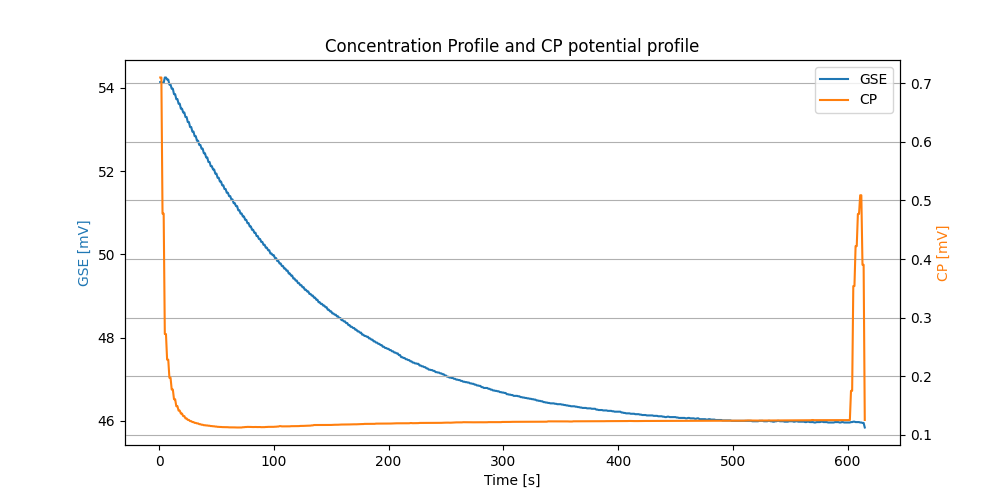

In [7]:
# make plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(data['Time [s]'], data['Potential [mV]'], label='GSE', marker=None, color='tab:blue')
ax2.plot(data['Time [s]'], data['CP Potential - iR [mV]'], label='CP', marker=None, color='tab:orange')

# label axis
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('GSE [mV]', color='tab:blue')
ax2.set_ylabel('CP [mV]', color='tab:orange')

plt.title('Concentration Profile and CP potential profile')

# legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
ax2.legend(all_handles, all_labels) #, loc="upper left")

# show plot
plt.grid(True)
plt.show()

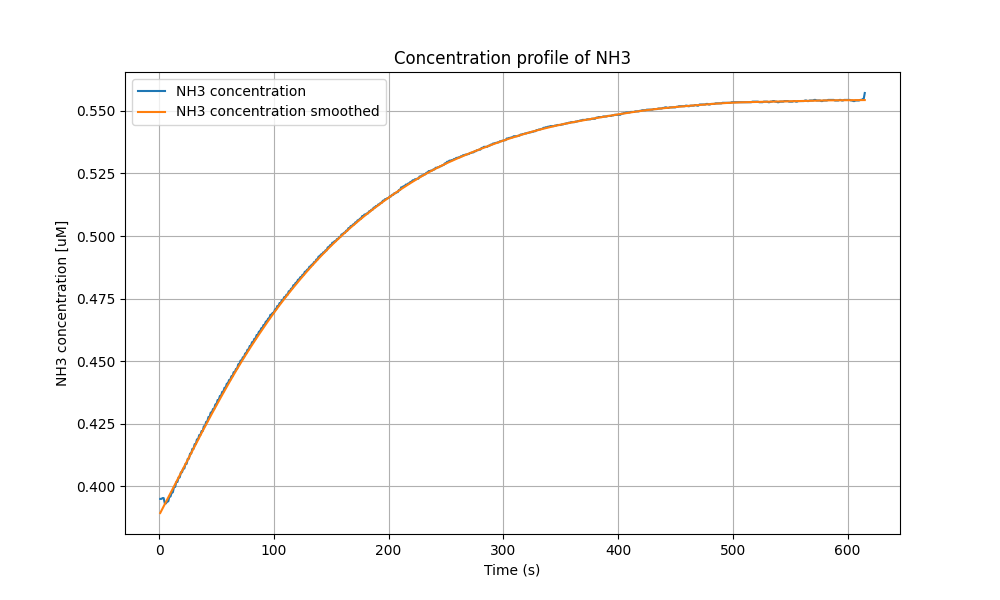

In [8]:
# make plot
plt.figure(figsize=(10, 6))
plt.plot(data['Time [s]'], data['conc_NH3 [µM]'], label='NH3 concentration', marker=None)
plt.plot(data['Time [s]'], data['conc_NH3_smoothed'], label='NH3 concentration smoothed')

# label axis
plt.xlabel('Time (s)')
plt.ylabel('NH3 concentration [uM]')

plt.title('Concentration profile of NH3')
plt.legend()

# show plot
plt.grid(True)
plt.show()

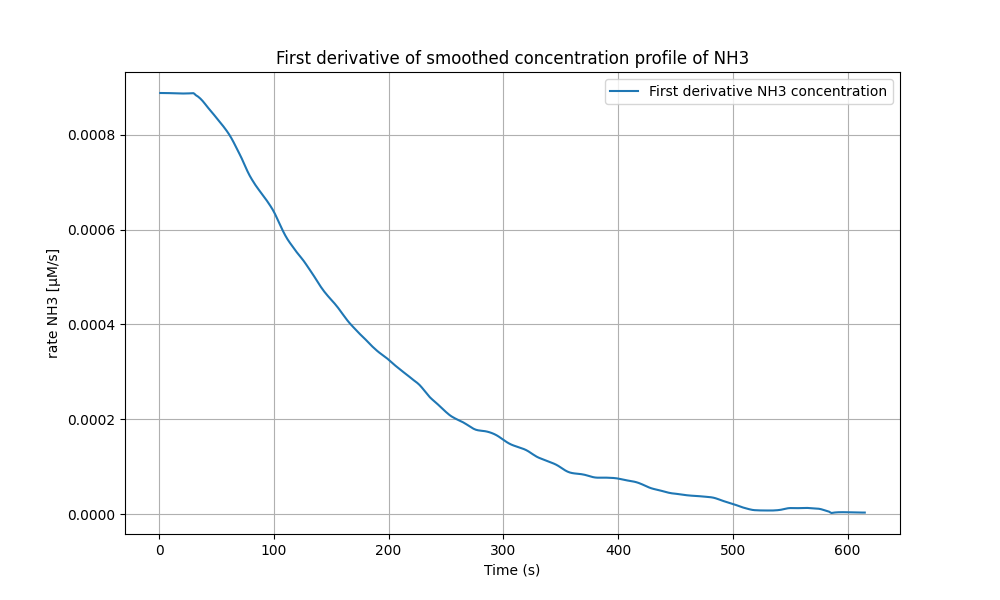

In [9]:
# make plot
plt.figure(figsize=(10, 6))
plt.plot(data['Time [s]'], data['rate NH3 [µM/s]'], label='First derivative NH3 concentration')

# label axis
plt.xlabel('Time (s)')
plt.ylabel('rate NH3 [µM/s]')

plt.title('First derivative of smoothed concentration profile of NH3')
plt.legend()

# show plot
plt.grid(True)
plt.show()

In [10]:
# extrema: change of sign of the derivative
signs = np.sign(data['conc_NH3_second_derivative'])
sign_change = np.diff(signs)

max_indices = np.where(sign_change == -2)[0] + 1  # derivative changes from + to -
min_indices = np.where(sign_change == 2)[0] + 1   # derivative changes from - to +

data['extremum'] = None
data.loc[max_indices, 'extremum'] = 'max'
data.loc[min_indices, 'extremum'] = 'min'


peaks = pd.DataFrame()
peaks = data.loc[data['extremum'].notna(), ['Time [s]', 'Potential [mV]', 'conc_NH3_smoothed', 'rate NH3 [µM/s]', 'rate NH3 [nmol/s*cm²]', 'FE [%]', 'extremum', 'conc_NH3_second_derivative']]

peaks

,Time [s],Potential [mV],conc_NH3_smoothed,rate NH3 [µM/s],rate NH3 [nmol/s*cm²],FE [%],extremum,conc_NH3_second_derivative
20,21.0,53.41,0.407142,0.000887,0.485876,147.671564,min,2.042057e-09
29,30.0,52.95,0.415130,0.000888,0.486249,147.785125,max,-8.582004e-07
383,384.0,46.26,0.547357,0.000077,0.042035,12.775731,min,2.712828e-08
387,388.0,46.25,0.547665,0.000077,0.042120,12.801504,max,-2.370969e-09
532,533.0,45.99,0.553644,0.000008,0.004115,1.250669,min,4.750060e-09
550,551.0,45.99,0.553818,0.000013,0.006970,2.118375,max,-2.674607e-09
555,556.0,45.99,0.553881,0.000012,0.006843,2.079665,min,1.131779e-08
563,564.0,45.97,0.553984,0.000013,0.007146,2.171861,max,-6.139715e-08
586,587.0,45.96,0.554202,0.000003,0.001462,0.444348,min,3.824893e-07
595,596.0,45.97,0.554235,0.000004,0.002185,0.663985,max,-4.799590e-09
